<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [89]:
import re
import string
import requests

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from bs4 import BeautifulSoup
import squarify

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [104]:
response = requests.get('https://www.indeed.com/viewjob?cmp=Mu-Sigma&t=Data+Scientist&jk=f02930acc46cd69b&sjdu=QwrRXKrqZ3CNX5W-O9jEveJgZ7DRbh_ySwPONsqRa9akiHf7zz11lDbJrZoIJgdvcgbqBHQPhbEDAZdxcFJddA&tk=1dhkgeuop5md3802&adid=300817378&pub=4a1b367933fd867b19b072952f68dceb&vjs=3')
soup = BeautifulSoup(response.text, 'html.parser')

In [108]:
desc = soup.find(id='jobDescriptionText')
print(desc.get_text())

About: -Mu Sigma is one of the world’s largest Decision Sciences and analytics firm. We help over 140 Fortune 500 clients, across 10 industry verticals, to institutionalize data-driven decision making, and to harness Big Data. We provide our clients with a holistic ecosystem of proprietary technology platforms, processes and people.With over 3500 Decision Sciences professionals, we pride in being a category and career defining company. As we continue to scale, we are also looking at hiring the right talent across various levels in our organization. Our unique talent management philosophy has been critically acclaimed by the likes of Harvard Business Review.Responsibilities: Design and implement distributed data processing pipelines using Spark, Hive, Python, and other tools and languages prevalent in the Hadoop ecosystem. Ability to design and implement end to end solution.Experience publishing RESTful API’s to enable real-time data consumption using OpenAPI specificationsExperience wi

In [2]:
# scraper imports
from urllib.parse import urlencode
from requests_html import HTMLSession
from multiprocessing.dummy import Pool
from itertools import chain

In [3]:
class IndeedJobListings:
    '''
    Multi-theaded Indeed Job Listings Crawler
    Usage:
    descriptions = IndeedJobListings('Data Scientist', 'West Palm Beach, FL')
                   .get_descriptions()
    '''
    def __init__(self, search_keyword, location, threads=12):
        self.threads = threads
        self.base_url = 'https://www.indeed.com'
        self.query_url = f'{self.base_url}/jobs?' +\
        urlencode({'q': search_keyword, 'l': location})
        self.session = HTMLSession()
    
    def _get_posting_urls(self, url):
        doc = self.session.get(url)
        posting_urls = [f'{self.base_url}{e.attrs["href"]}' 
                        for e in doc.html.find('.jobtitle.turnstileLink')]
        return posting_urls

    def _get_description_text(self, url):
        doc = self.session.get(url)
        description_text = doc.html.find('#jobDescriptionText')[0].text
        return description_text
                        
    def get_descriptions(self, pages=1):
        list_urls = [self.query_url] + [f'{self.query_url}&start={x*10}'
                                        for x in range(1, pages)]
        p = Pool(self.threads)
        post_urls = chain(*p.map(self._get_posting_urls, list_urls))
        descriptions = p.map(self._get_description_text, post_urls)
        return descriptions

listings = IndeedJobListings('Data Scientist', 'West Palm Beach, FL')
descriptions = listings.get_descriptions(pages=10)

In [8]:
descriptions[1]

"About: -\nMu Sigma is one of the world’s largest Decision Sciences and analytics firm. We help over 140 Fortune 500 clients, across 10 industry verticals, to institutionalize data-driven decision making, and to harness Big Data. We provide our clients with a holistic ecosystem of proprietary technology platforms, processes and people.\nWith over 3500 Decision Sciences professionals, we pride in being a category and career defining company. As we continue to scale, we are also looking at hiring the right talent across various levels in our organization. Our unique talent management philosophy has been critically acclaimed by the likes of Harvard Business Review.\nResponsibilities:\nDesign and implement distributed data processing pipelines using Spark, Hive, Python, and other tools and languages prevalent in the Hadoop ecosystem. Ability to design and implement end to end solution.\nExperience publishing RESTful API’s to enable real-time data consumption using OpenAPI specifications\nE

In [9]:
len(descriptions)

149

In [88]:
#url = 'https://www.indeed.com/jobs?q=data+scientist&l=West+Palm+Beach%2C+FL'

## 2) Use Spacy to tokenize / clean the listings 

In [16]:
##### Your Code Here #####
df = pd.read_csv('./data/job_listings.csv')
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [45]:
df['description'] = df['description'].apply(lambda x: BeautifulSoup(x)
                                            .get_text()[2:]
                                            .replace('\\n', ' '))
                                        

In [21]:
df['description'][0]

'Job Requirements: Conceptual understanding in Machine Learning models like Naive Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now"'

In [9]:
nlp = spacy.load('en_core_web_lg')

In [46]:
df['tokens'] = df['description'].apply(lambda row: 
                                       [x.lemma_ for x in nlp(row.lower()) 
                                        if (x.is_stop == False 
                                            and x.is_punct == False) 
                                        and x.pos_ != "-PRON-"  
                                       ])

In [47]:
df.head()

,Unnamed: 0,description,title,tokens
0,0,b Requirements: Conceptual understanding in Ma...,Data scientist,"[b, requirement, conceptual, understanding, ma..."
1,1,"b Description As a Data Scientist 1, you will...",Data Scientist I,"[b, description, , data, scientist, 1, help, ..."
2,2,a Data Scientist you will be working on consu...,Data Scientist - Entry Level,"[ , data, scientist, work, consult, business, ..."
3,3,",969 - $6,756 a monthContractUnder the general...",Data Scientist,"[969, $, 6,756, monthcontractunder, general, s..."
4,4,cation: USA \xe2\x80\x93 multiple locations 2+...,Data Scientist,"[cation, usa, \xe2\x80\x93, multiple, location..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [48]:
##### Your Code Here #####
vect = CountVectorizer(stop_words='english', min_df=.05, max_df=.9)

In [49]:
vect.fit(df['description'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.05,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [50]:
job_matrix = vect.transform(df['description'])

In [51]:
job_df = pd.DataFrame(job_matrix.todense(), columns = vect.get_feature_names())
job_df.head()

,000,10,100,2019,40,abilities,ability,able,academic,access,...,x99,x99ll,x99re,x99s,x99t,x9d,xe2,year,years,york
0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,2,0,2,2,0,0,8,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


## 4) Visualize the most common word counts

In [52]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [53]:
wc = count(df['tokens'])

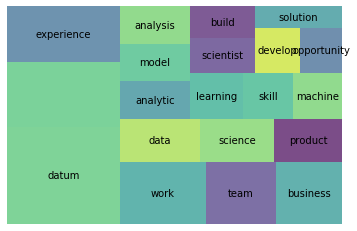

In [54]:
job_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=job_top20['pct_total'], label=job_top20['word'], alpha=.7)
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [61]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
sparse = tfidf.fit_transform(df['description'])
tf_job_df = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

In [62]:
tf_job_df.head()

,ability,able,access,achieve,action,actionable,ad,additional,address,advanced,...,x99,x99ll,x99re,x99s,x9d,xc2,xe2,xef,year,years
0,0.203031,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000
1,0.033764,0.0,0.0,0.0,0.000000,0.000000,0.0,0.060344,0.0,0.00000,...,0.118341,0.0,0.127886,0.066824,0.0,0.0,0.225919,0.0,0.065415,0.0000
2,0.089657,0.0,0.0,0.0,0.000000,0.152045,0.0,0.000000,0.0,0.10679,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000
3,0.000000,0.0,0.0,0.0,0.123063,0.000000,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.125896,0.0000
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.165657,0.0,0.000000,0.1797


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [64]:
# instantiate 
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

In [69]:
nn.fit(tf_job_df)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [76]:
nn.kneighbors([tf_job_df.iloc[0]])

(array([[0.        , 1.17515824, 1.17515824, 1.18025936, 1.18793563]]),
 array([[  0, 138,  42, 325, 338]]))

In [78]:
df['description'][0]

'b Requirements: Conceptual understanding in Machine Learning models like Naive Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now"'

In [79]:
df['description'][138]

"b Description  5-10 years hands-on experience in forecasting, Machine learning, and/or optimization modeling, and simulation.Working knowledge of predictive modeling and ML tools (scikit, R)Experience with data acquisition tools (e.g. SQL, Apache Spark etc.), large datasets (Hadoop) and data miningProgramming language (Java, scripting language like Python.Good understanding of NLP conceptsHave understanding of machine learning conceptsHave understanding of Hadoop (specifically HIVE/HDFS/Kafka)Fine on programming concepts \\xe2\\x80\\x93 pythonStronger skills on image analysis and more experience in Machine Learning / Deep Learning  Qualifications  null  Additional Information  All your information will be kept confidential according to EEO guidelines.'"

In [87]:
ideal_description = ['This position is responsible for developing algorithms, modeling techniques, and optimization methods that support many aspects of NextEra and FPL business. Employees in this role use knowledge of machine learning, optimization, statistics, and applied mathematics along with abilities in software engineering with a focus on distributed computing and data storage infrastructure (e. g. Big Data ).Job Duties & Responsibilities • Develops machine learning, optimization and other modeling solutions • Prepares comprehensive documented observations, analyses and interpretations of results including technical reports, summaries, protocols and quantitative analyses • Works with a variety of datasets, including timeseries data and big data requiring analysis on distributed computing platforms • Writes software in R, Python or similar languages and contributes code to product development teams']
ideal_description

['This position is responsible for developing algorithms, modeling techniques, and optimization methods that support many aspects of NextEra and FPL business. Employees in this role use knowledge of machine learning, optimization, statistics, and applied mathematics along with abilities in software engineering with a focus on distributed computing and data storage infrastructure (e. g. Big Data ).Job Duties & Responsibilities • Develops machine learning, optimization and other modeling solutions • Prepares comprehensive documented observations, analyses and interpretations of results including technical reports, summaries, protocols and quantitative analyses • Works with a variety of datasets, including timeseries data and big data requiring analysis on distributed computing platforms • Writes software in R, Python or similar languages and contributes code to product development teams']

In [84]:
ideal_vector = tfidf.transform(ideal_description)

In [85]:
nn.kneighbors(ideal_vector.todense())

(array([[1.13417063, 1.14230222, 1.15442886, 1.15649124, 1.15944293]]),
 array([[404, 144, 347, 321, 285]]))

In [86]:
df['description'][404]

"r Products, Inc., a Fortune 500 manufacturer of industrial gases, has an immediate opening for a Data Scientist at our Corporate Headquarters in Allentown, Pennsylvania.  This position is in the Modeling and Data Sciences team, a center-of-excellence in our Technology organization focused on improving the profitability and reliability of our existing assets and the competitiveness of our new product offerings. We are looking for a talented data scientist with an interest and expertise in various aspects of optimization, data analytics, and hybrid modeling.  The incumbent will be responsible for developing, conducting and participating in projects involving one or more of the following areas: life-based reliability modeling, real-time optimization, process/equipment condition monitoring, and innovative IIOT solutions. Specific activities will focus on one or more of the following areas: Real-Time Optimization using Empirical Modeling of Chemical Processes, Stochastic Simulation/Optimiz

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 